This notebook is my walkthrough of the Intro to Tensorflow 2.0 course on Udacity, starting from lesson 3. I am going to take notes on what I am doing and then it will of course have the code. Hooray.

The first thing I want to do is bring in the tensorflow datasets that I will be using later.

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (3.2.1)
You should consider upgrading via the 'pip install --upgrade pip' command.


Next, we need to bring in tensorflow itself.

In [2]:
import tensorflow as tf

Now bring in the datasets and the other useful libraries.

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

We are going to use the Fashion-MNIST dataset, like all the machine learning courses do. We had better bring the dataset in. We are also going to use the pre-split training and test sets here.

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

The dataset has integer (factor) labels instead of descriptive labels, so we are going to give it more understandable output. 

In [5]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
                'Sneaker', 'Bag', 'Ankle boot']

Now just a quick exploration of the size of the data...

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


Lots of data, 70,000 pictures. The value of the pixels is on the usual chromatic scale of [0,255]; we need to normalize it to the [0,1] scale.

In [7]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

## Now we map each element of the train and test datasets to the normalize function
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

## And we want to hold everything in the cache so that it trains faster! 
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

Let's now plot an image and see what it looks like.

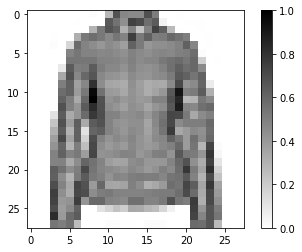

In [8]:
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))
    
# plot image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid=False
plt.show()

Looks like clothing, alright. Pullover maybe? Well, we can see that the pixels are shaded, with higher numbers indicating a darker square. That's how the algorithm is going to learn the difference between clothing, by seeing which pixels are what shade of gray. Cool

Let's try plotting a 5x5 square of images!

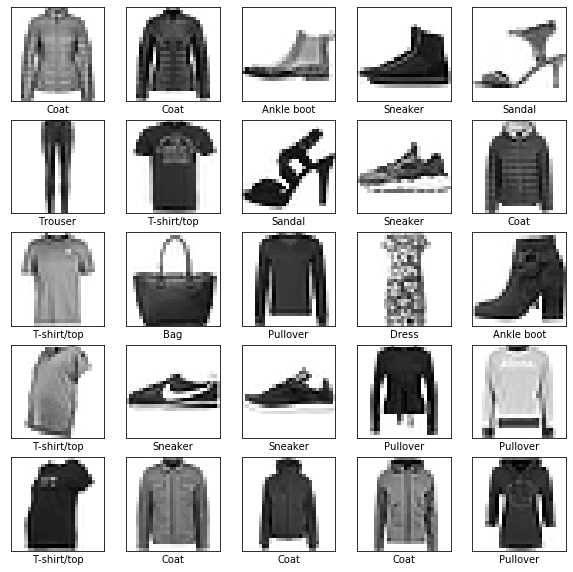

In [9]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid = False
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_labels[label])
    i += 1
plt.show()

Nice. This is pretty cool stuff. But it is time to build the model! Yaaaay!

Start by configuring the layers. We need to flatten the 28x28 pixels into a vector of hues. That is done in the Flatten layer. Then, we need a Dense ReLU layer that learns the patterns in the pixels. And then we need a Dense softmax layer that returns the probability of each label. 

ReLU is good for all kinds of non-linear models, so it is a good starting place for most applications. Softmax is always the layer to use when you want probability output. 

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Models in tensorflow have to be compiled, because they are composed of multiple layers. Think of it like...like a particle filter, right? A mesh grid of statistical models that filters out the noise and leaves behind the measurable signal. Sweet.

The Adam optimizer is a kind of gradient descent that works well and is quick. I downloaded a paper about it. I should read that.
The loss function here is good when there are more than two labels. For one-hot encoding, we can use CategoricalCrossentropy. Look for papers on this.
The metric used here is accuracy, which is the proportion of correct predictions. 

In [12]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

Okay. The model has been compiled. It is now time to train it. 

dataset.repeat() causes the training to repeat. The epochs parameter controls how many times it repeats.
dataset.shuffle(n) randomizes the order of the training dataset, so the model cannot just memorize them in order.
dataset.batch(m) tells the moel.fit function how many examples to use in a batch when updating the model variables.

The actual training is done with a call to the model.fit method. We feel the training dataset to the model, and the model learns the patterns.

In [13]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4948 - accuracy: 0.8250
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3787 - accuracy: 0.8630
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3356 - accuracy: 0.8776
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3104 - accuracy: 0.8862
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2981 - accuracy: 0.8895


Each epoch, the loss function decreases (this is what the optimizer aims for), and the accuracy increases (also good). Eventually, in only 5 epochs, the model has gained an accuracy of about 89%!

Now let's see how it does on the test dataset. This is done with the model.evaluate method, feeding it the test_dataset and telling it how many batches it'll have to do.

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Accuracy on test dataset:", test_accuracy)                                       

313/313 [==============================] - 2s 6ms/step - loss: 0.3736 - accuracy: 0.8684
Accuracy on test dataset: 0.8684


It does about 2% worse on the test set, which is wonderful! Properly fit models do just a bit worse on test data. Overfit models do much worse on test data, underfit models do equally badly on both training and test data.

Now that we have a well-fit model, we can use it to make predictions. Let's make a prediction for a given example from the test set.

In [16]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [17]:
predictions.shape

(32, 10)

The above output tells us that the prediction predicts for a whole batch of 32 images, and it has 10 outputs for each image. Each of those outputs is the probability that the garment in the picture deserves the 10 possible labels. Let's look at probabilities for the first image.

In [18]:
predictions[0]

array([2.9827435e-05, 3.6551348e-06, 1.1757843e-02, 1.0294479e-05,
       9.7854054e-01, 3.8300163e-09, 9.6518211e-03, 1.0280193e-09,
       6.0562115e-06, 4.3109510e-10], dtype=float32)

This numeric array output shows that the garment is certainly probably not '#10', an Ankle boot...but it is likely to be '#5', a Coat. Let's have the computer tell us that more explicitly.

In [19]:
np.argmax(predictions[0])

4

In [20]:
test_labels[0]

4

In [21]:
print("The most likely label is:", class_labels[np.argmax(predictions[0])])

The most likely label is: Coat


Now, let's make a graph that shows us the full set of class predictors.

In [26]:
def plot_image(i, predictions_array, true_label, images):
    predictions_array, true_label, img = predictions_array[i], true_label[i], images[i]
    plt.grid=False
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_labels[predicted_label],
                                        100*np.max(predictions_array),
                                        class_labels[true_label]),
              color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid = False
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Those two functions just plot the shit and color it up nice.

Now let's have a look.

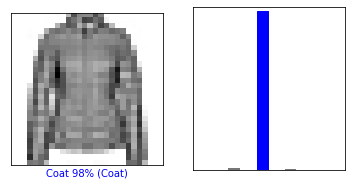

In [27]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

The algorithm predicted that it was a coat with 98% certainty. And it was right! Yeah!

Let's look at another.

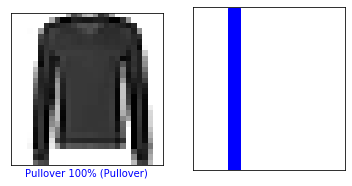

In [29]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Beautiful. Now let's try a bunch at the same time!

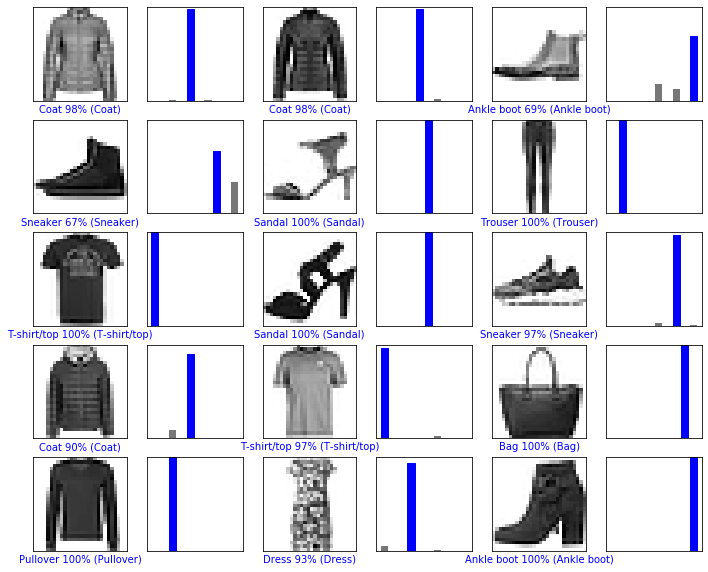

In [30]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

It absolutely fucking nailed all of these. The most uncertainty was in the Sneaker at (2,1), followed close after by the Ankle Boot at (1,3). Because they almost look alike.

Now let's predict about a single image.

In [31]:
img = test_images[0]
print(img.shape)

(28, 28, 1)


Because the model runs on a batch of images at a time, we need to add this single image to a list. Then we can do the predictions.

In [32]:
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [33]:
predictions_single = model.predict(img)
print(predictions_single)

[[2.9827435e-05 3.6551348e-06 1.1757838e-02 1.0294470e-05 9.7854054e-01
  3.8300092e-09 9.6518211e-03 1.0280193e-09 6.0562115e-06 4.3109510e-10]]


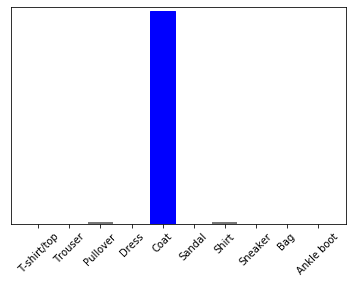

In [34]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_labels, rotation=45)

In [35]:
np.argmax(predictions_single[0])

4

In [37]:
print("This is a picture of a",class_labels[np.argmax(predictions_single[0])])

This is a picture of a Coat


Thus endeth lesson 3.